<div style="text-align: right" align="right"><i>Peter Norvig<br>2017, updated 2026</i></div>

# The Convex Hull Problem

Pound a bunch of nails into a board, then stretch a rubber band around them and let the rubber band snap taut, like this:

![](https://ds055uzetaobb.cloudfront.net/uploads/tantSbEgDe-ch2.gif)

The rubber band has traced out the **convex hull** of the set of nails. It turns out this is an important problem with applications in computer graphics, robot motion planning, geographical information systems, ethology, and other areas.
More formally, we say that:

*Given a finite set, **P**, of points in a plane, the convex hull of **P** is a polygon, **H**, such that:*

- *Every point in **P** lies either on or inside of **H**.*
- *Every vertex of **H** is a point in **P**.*
- **H** *is convex: a line segment joining any two vertexes of **H** either is an edge of **H** or lies inside **H**.*


In this notebook we develop an algorithm to find the convex hull. The first thing to do is decide how we will represent the objects of interest.

# Points, Sets of Points, and Polygons

Here are the types I want to define:

- **Point**: a class such that `Point(3, 4)` returns a point `p` such that `p.x` is 3 and `p.y` is 4.
- **Set of Points**: a Python set: `{Point(0,0), Point(3,4), ...}` The function `Points(n)` will return a set of `n` random points.
- **Polygon**: an ordered list of vertex points.

First, get the necessary imports done, then implement the three types:

In [1]:
import collections
import math
import matplotlib.pyplot as plt
import random
import re
import time

In [2]:
Point   = collections.namedtuple('Point', 'x, y')
Polygon = list[Point]

def Points(n: int) -> set[Point]:
    """Generate n random points within a unit square."""
    return {Point(random.random(), random.random())
            for _ in range(n)}

In [3]:
Points(3)

{Point(x=0.019776103178765214, y=0.05751328325941196),
 Point(x=0.08201516948907406, y=0.831040189361657),
 Point(x=0.10325343098110484, y=0.36755973349968385)}

# Visualizing Points and Line Segments


To visualize points, I'll define a function `plot_points`.  We will want to be able to see:
- The **points** themselves. 
- Optionally, **line segments** between points. An optional `style` parameter allows you to specify whether you want lines or not, and what color they should be. The lines go from point to point in order; if you want the lines to close
back from the last point to the first (to form a complete polygon), specify `closed=True`. 
- Optionally, **labels** on the points that let us distinguish one from another. You get
labels (integers from 0 to *n*) if you specify `labels=True`.

In [4]:
def plot_points(points, style='r.', labels=False, closed=False) -> None: 
    """Plot a collection of points. Optionally change the line style, label points with numbers, 
    and/or form a closed polygon by closing the line from the last point to the first."""
    if closed:
        points = points + [points[0]]
    plt.plot([p.x for p in points], [p.y for p in points], style)
    if labels:
        for (i, (x, y)) in enumerate(points):
            plt.text(x, y, f'  {i}')
    plt.axis('scaled'); plt.axis('off')

# Convexity


We want to make a *convex* hull, so we need to understand what makes a polygon *convex*. or concave. Here's a convex polygon:

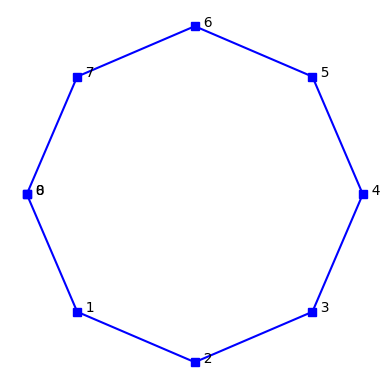

In [5]:
octagon = [Point(-10, 0), Point(-7, -7), Point(0, -10), Point(+7, -7), 
           Point(+10, 0), Point(+7, +7), Point(0, +10), Point(-7, 7)]
plot_points(octagon, 'bs-', labels=True, closed=True)

If you start at point 0 at the left and proceed in order counterclockwise around the octagon, following edges from point to point, you can see that at every vertex you are making a **left** turn.

Now let's consider a concave (non-convex) polygon:

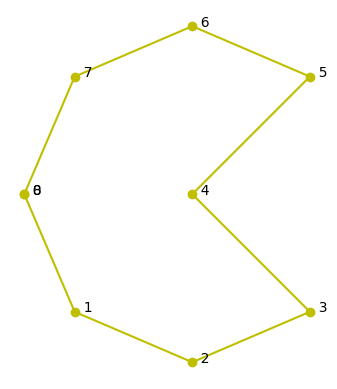

In [6]:
pacman = octagon[:4] + [Point(0, 0)] + octagon[5:]
plot_points(pacman, 'yo-', labels=True, closed=True)

As you move counterclockwise around the pacman, you turn **right** at 4. That's the point where the polygon is concave; you can draw a line from 3 to 5 that is poutside the polydgon.  That leads to the idea: **a polygon is convex if there are no right turns** as we go around the polygon counterclockwise.  

# Turn Directions


Now how do we determine if a turn from point A to B to C is a left turn at B or a right turn (or straight)? Consider this diagram:

<img src="http://norvig.com/convexhull.jpg">

It is a left turn at B if angle &beta;  is bigger than angle &alpha;; in other words, if &beta;'s opposite-over-adjacent ratio is bigger than &alpha;'s: 

    (C.y - B.y) / (C.x - B.x)   >   (B.y - A.y) / (B.x - A.x)
    
But if we did that computation, we'd need special cases for when each denominator is zero.  So multiply each side by the denominators:

    (B.x - A.x) * (C.y - B.y)   >   (B.y - A.y) * (C.x - B.x) 
    
(*Note:* This step should make you very nervous! In general, multiplying both sides of an inequality by a negative number reverses the inequality, and here the denominators might be negative. In this case it works out; basically because we are doing two multiplications so that negatives cancel out, but [the math proof](https://en.wikipedia.org/wiki/Cross_product) is tricky, involving some concepts in vector algebra, so I won't duplicate it here; instead I will provide good test coverage below.)
    
That leads to the function definition: 

In [7]:
def is_left_turn(A: Point, B: Point, C: Point) -> bool:
    """Is the turn from A->B->C a left turn?"""
    delta = (B.x - A.x) * (C.y - B.y)  -  (B.y - A.y) * (C.x - B.x)
    return delta > 0

# Sketch of Convex Hull Algorithm


Now we have the first part of a strategy to find the convex hull:

***Travel a path along the points in some order. (It is not yet clear exactly what order.) Any point along the way that does not mark a left-hand turn is not part of the hull.***

What's a good order? Let's see what happens if we start at the leftmost point and work our way to the rightmost.  We can achieve that ordering by calling the built-in function `sorted` on the points (since points are tuples, `sorted` sorts them lexicographically: first by their first component, `x`, and if there are ties, next by their `y` component). I will define a function to plot the partial hull as we go:

In [8]:
def plot_partial_hull(points, hull_indexes=()) -> None:
    """Plot all the points as labeled red dots, with a blue line for the points named by `hull_indexes`."""
    plot_points(points, labels=True)
    plot_points([points[i] for i in hull_indexes], 'bs-')

Given a sorted list of 11 points, let's start at the leftmost point and keep going until we make a right turn:

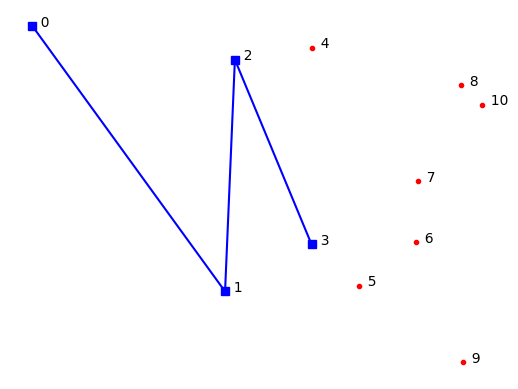

In [9]:
xys = [(40, 190), (138, 55), (143, 173), (182, 79), (182, 179), (206, 58), 
       (235, 80), (236, 111), (258, 160), (259, 19), (269, 150)]
pts = sorted(Point(x, y) for (x, y) in xys)

plot_partial_hull(pts, [0, 1, 2, 3])

There is a right turn at 2, so remove it from the hull and continue on to points 4 and 5:

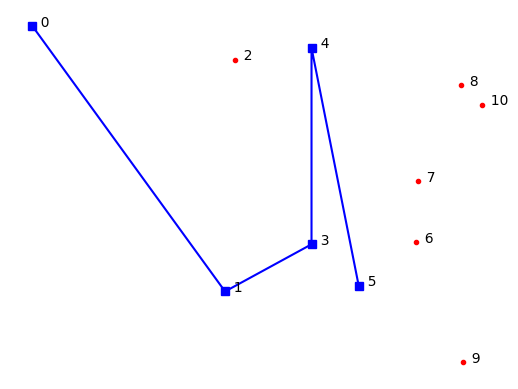

In [10]:
plot_partial_hull(pts, [0, 1, 3, 4, 5])

That's a right turn at 4, so remove it:

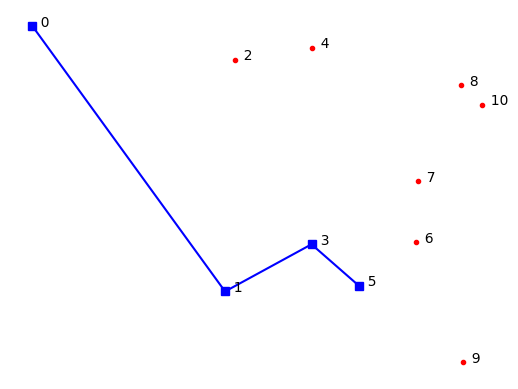

In [11]:
plot_partial_hull(pts, [0, 1, 3, 5])

But now we see point 3 is also a right turn. The addition of one new point (5) can remove multiple points (4 and 3) from the hull. We remove 3 and move on to 6, 7, and 8:

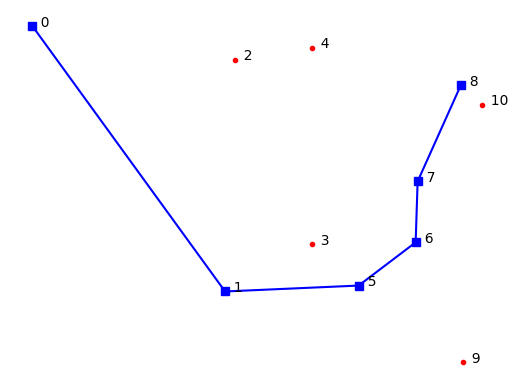

In [12]:
plot_partial_hull(pts, [0, 1, 5, 6, 7, 8])

Point 7 is a right turn so we remove 7 and move on to 9:

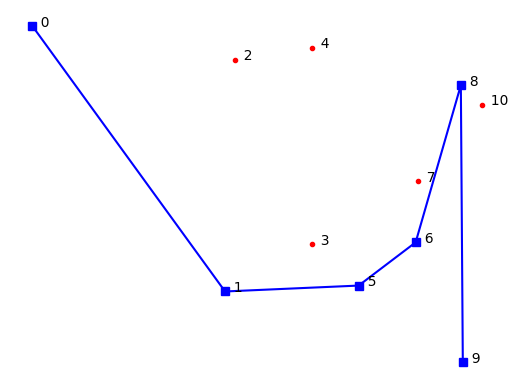

In [13]:
plot_partial_hull(pts, [0, 1, 5, 6, 8, 9])

Point 8 is a right turn, so we remove 8. But then 6 and 5 are also right turns, so they too are removed. We proceed on to 10:

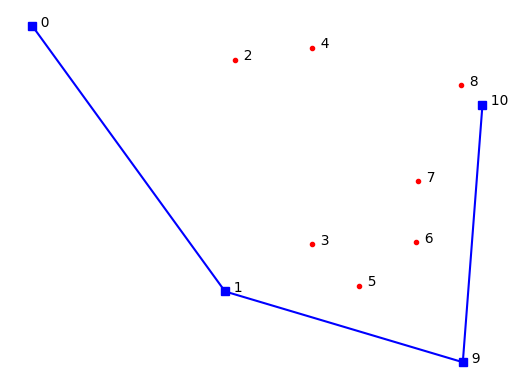

In [14]:
plot_partial_hull(pts, [0, 1, 9, 10])

Now what do we do? We got all the way to the end of our set of 11 points, but we only got half the hull (the lower half).  Well, if looking at all the points in left-to-right order gives us the lower half of the hull, maybe looking at all the points in right-to-left order will give us the upper half.  Let's try. 

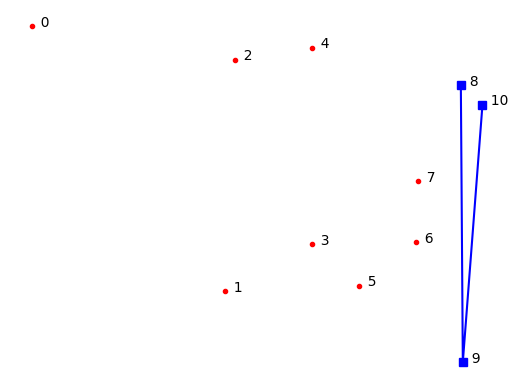

In [15]:
plot_partial_hull(pts, [10, 9, 8])

Point 9 is a right turn; remove it and move on:

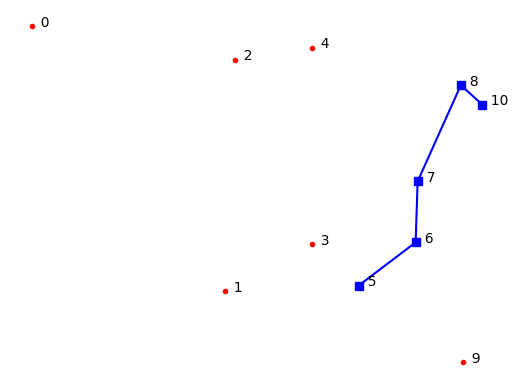

In [16]:
plot_partial_hull(pts, [10, 8, 7, 6, 5])

Now 6 is a right turn and must be removed. We could continue step-by-step, but I'll just skip to the end:

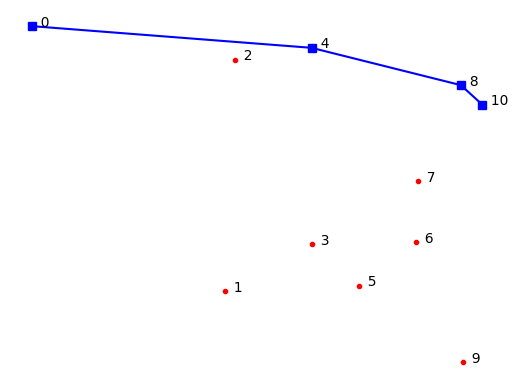

In [17]:
plot_partial_hull(pts, [10, 8, 4, 0])

Let's bring back the lower hull and concatenate it with the upper hull:

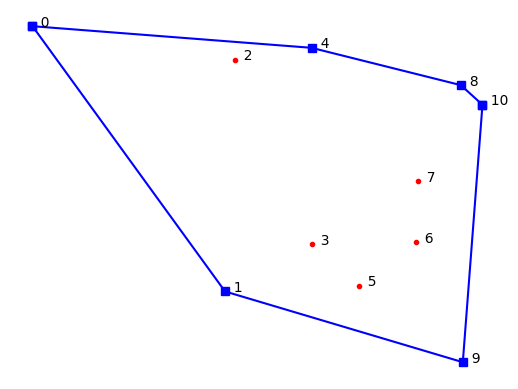

In [18]:
plot_partial_hull(pts, [0, 1, 9, 10] + [10, 8, 4, 0])

That's all there is to the basic idea of the algorithm, but there are a few edge cases to worry about: 

* **Degenerate polygons**: A triangle has 3 sides, and no "true" polygon has fewer, but it is possible to have a set of 0, 1, or 2 points. Such a set of points is convex because there is no way to draw a line segment that goes outside the points.

* **Colinear points:** if three or more points are colinear, we could keep them all on the hull, or we could keep only the two "outside" ones.  I decided to make the convex hull be the minimal possible set of points, and thus only keep the outside points. 

* **First and last points:** An astute reader might have noticed that our algorithm only rejects the middle point, point B, in the A->B->C turn. That means that the first and last point in sorted order will never be a candidate for rejection, and thus will always end up on the hull.  Is that correct?  Yes it is. The first point is the leftmost point, the one with lowest `x` value (and if there are ties, it is the lowest-leftmost point). That is an extreme corner, so it should always be on the hull. A similar argument holds for the last point in sorted order.




# Implementation of Convex Hull Algorithm

We're ready to code up the algorithm: sort the points, find the upper and lower half hulls, and put them together:

In [19]:
def convex_hull(points) -> Polygon:
    """Find the convex hull of a set of points."""
    if len(points) <= 3: # Degenerate polygons and triangles
        return points
    # Find the two half-hulls ...
    sorted_points = sorted(points)
    upper = half_hull(sorted_points)
    lower = half_hull(reversed(sorted_points))
    return upper + lower[1:-1] # ... and append them, but don't repeat first and last points

def half_hull(sorted_points) -> list[Point]:
    """Return the half-hull from following points in sorted order, eliminating right turn points."""
    # Add each point C in order; remove previous point B if A->B-C is not a left turn.
    hull = []
    for C in sorted_points:
        # if A->B->C is not a left turn ...
        while len(hull) >= 2 and not is_left_turn(hull[-2], hull[-1], C):
            hull.pop() # ... then remove B from hull.
        hull.append(C)
    return hull

# Visualization of Results

To visualize the results of the algorithm, I'll define a function to call `convex_hull` and plot the results: 

In [20]:
def plot_convex_hull(points) -> None:
    """Find the convex hull of these points; plot the hull in blue and the interior points in red."""
    hull = convex_hull(points)
    plot_points(points)
    plot_points(hull, 'bs-', closed=True)
    print(len(hull), 'of', len(points), 'points are on the convex hull')

First the set of 11 random points, and then  1000 random points:

6 of 11 points are on the convex hull


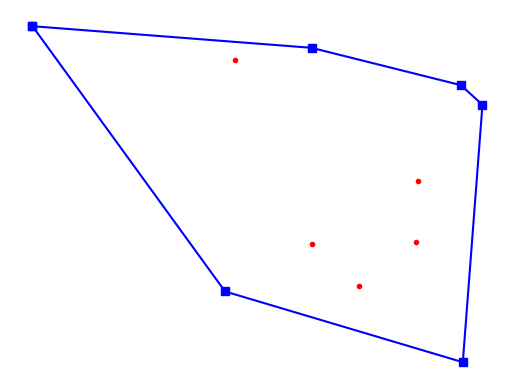

In [21]:
plot_convex_hull(pts)

16 of 1000 points are on the convex hull


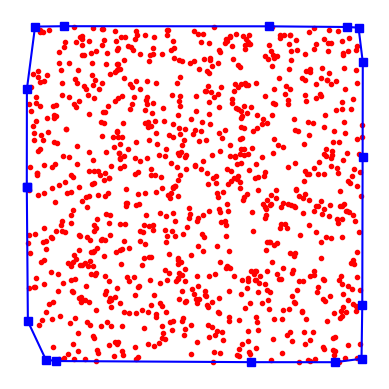

In [22]:
plot_convex_hull(Points(1000))

Now the octagon and pacman shapes:

8 of 8 points are on the convex hull


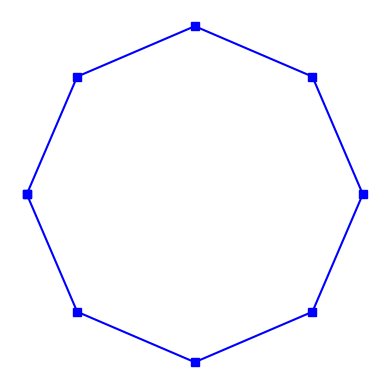

In [23]:
plot_convex_hull(octagon)

7 of 8 points are on the convex hull


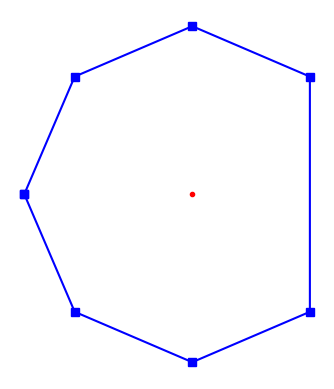

In [24]:
plot_convex_hull(pacman)

Next I'll use a set of latitude/longitude  coordinates of US cities, taken from my [Traveling Salesperson Problem notebook](TSP.ipynb):

17 of 1089 points are on the convex hull


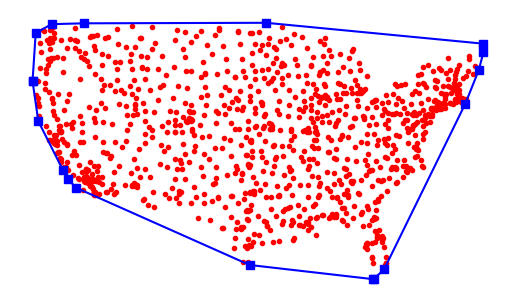

In [25]:
def parse_cities(text: str, skip=('AK', 'HI'), longitude_scale=-3/4) -> set[Point]:
    """Extract a set of Points from text, skipping the specified states."""
    # Entries are of the form "[FLG]  35.13  111.67  Flagstaff,AZ"
    entries = re.findall(r'([\d.]+)\s+([\d.]+).+([A-Z][A-Z])', text)
    return {Point(longitude_scale * float(long), float(lat))
                  for (lat, long, state) in entries
                  if state not in skip}

USA = parse_cities(open('latlong.htm').read())
plot_convex_hull(USA)

I wanted to make sure that a regular grid gets just the 4 corner points on the hull:

4 of 100 points are on the convex hull


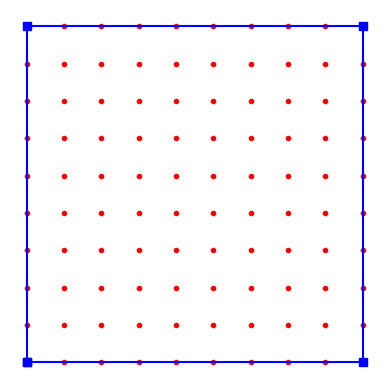

In [26]:
grid = {Point(x, y) for x in range(10) for y in range(10)}

plot_convex_hull(grid)

Here is a variant with some noise thrown in:

14 of 100 points are on the convex hull


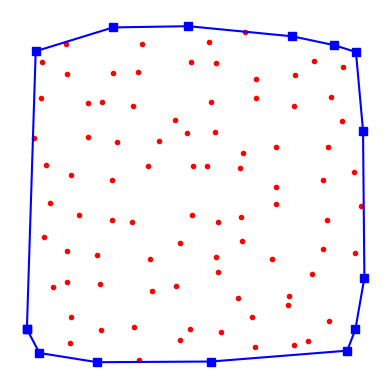

In [27]:
def noisy(points, delta=0.4) -> set[Point]: 
    """Add some uniform noise to each of the points."""
    def noise(): return random.uniform(-delta, +delta)
    return {Point(x + noise(), y + noise())
            for (x, y) in points}

plot_convex_hull(noisy(grid))

Some stranger shapes:

20 of 720 points are on the convex hull


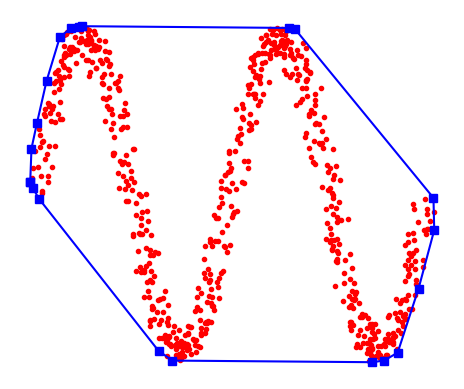

In [28]:
sine = {Point(math.radians(d),  5 * math.sin(math.radians(d))) for d in range(720)}
plot_convex_hull(noisy(sine))

19 of 360 points are on the convex hull


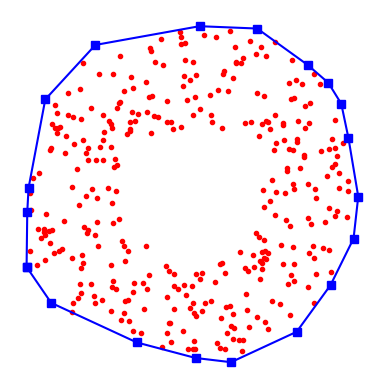

In [29]:
donut = {Point(math.sin(math.radians(d)), math.cos(math.radians(d))) for d in range(360)}

plot_convex_hull(noisy(donut))

# Complexity of run time and number of points on hull

Now I want to examine what happens to the run time as the number of points increases, and also what happens to the number of points on the hull. The function `hull_stats` returns the mean number of points on the convex hull, and the mean run time, for `k` repetitions of a call to `convex_hull(Points(n))`. The function, `plot_hull_stats` calls `hull_stats` and plots the results.

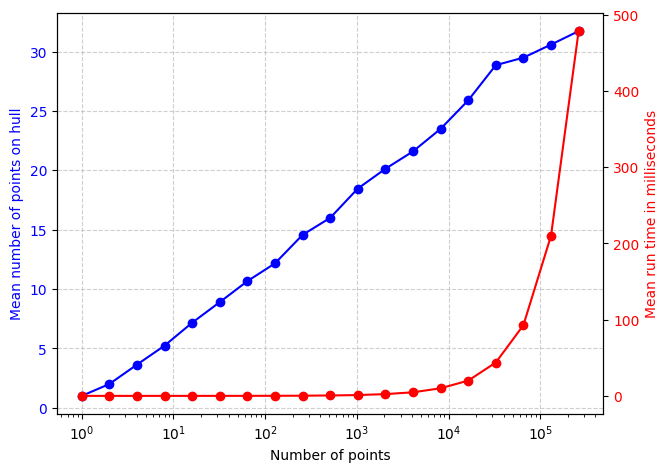

In [30]:
def hull_stats(n: int, k=30) -> tuple[float, float]:
    """Run convex_hull(Points(n)) k times, return mean number of points on hull and mean run time in milliseconds."""
    t0 = time.process_time()
    total_hull = sum(len(convex_hull(Points(n))) for _ in range(k))
    t1 = time.process_time()
    return total_hull / k, (t1 - t0) * 1000 / k

def plot_hull_stats(ns: list[int]) -> None:
    """A plot with two axes, for the mean hull sizes and mean run times for each n in ns."""
    stats = map(hull_stats, ns)
    hulls, times = list(zip(*stats)) # Transpose the stats matrix
    fig, ax1 = plt.subplots()
    plt.grid(True, linestyle='--', alpha=0.6)
    ax2 = ax1.twinx()
    ax1.set_xlabel('Number of points')
    fig.tight_layout()  # Ensures everything fits without overlapping
    
    def plot(ax, color, values, name) -> None:
        ax.set_xscale('log')
        ax.set_ylabel(name, color=color)
        ax.plot(ns, values, color=color, marker='o')
        ax.tick_params(axis='y', labelcolor=color)

    plot(ax1, 'blue', hulls, 'Mean number of points on hull')
    plot(ax2, 'red',  times, 'Mean run time in milliseconds')

ns = [2 ** i for i in range(19)]
plot_hull_stats(ns)

The number of points on the hull of ppoints sampled uniformly from a square is (roughly) a straight line on the log graph, which means it is *O*(log *n*). This agrees with the [literature](https://arxiv.org/abs/1111.5340). The [literature](https://en.wikipedia.org/wiki/Convex_hull_algorithms) also says the run time should be *O*(*n* log *n*), and just from eyeballing the plot that looks right (although it would be more convincing if we did a statistical test to verify it). The rightmost point is for sets with *n* = 2<sup>18</sup> =  262,144 points, and we compute their convex hulls in less than half a second on average (and find an average of about 33 points on the convex hull).

# Tests

So far, everything looks good! But I would gain even more confidence if we could pass a test suite:

In [31]:
def tests() -> bool:
    """Some unit tests."""
    assert is_left_turn(octagon[0], octagon[1], octagon[2])
    assert is_left_turn(octagon[2], octagon[3], octagon[4])
    assert is_left_turn(octagon[1], octagon[0], octagon[7]) == False
    assert is_left_turn(octagon[5], octagon[6], octagon[7])
    assert is_left_turn(octagon[2], octagon[1], octagon[0]) == False
    assert is_left_turn(pacman[1], pacman[2], pacman[3])
    assert is_left_turn(pacman[3], pacman[4], pacman[5]) == False
    assert is_left_turn(Point(0, 0), Point(-1, -1), Point(2, 2)) == False
    
    A, B = Point(-2, -2), Point(0, 0)
    assert is_left_turn(A, B, Point(1, 3))
    assert is_left_turn(A, B, Point(2, 2)) == False
    assert is_left_turn(A, B, Point(3, 1)) == False
    assert is_left_turn(A, B, Point(-1, 1))
    assert is_left_turn(A, B, Point(-1, -4)) == False
    assert is_left_turn(A, B, Point(-1, -1)) == False
    assert is_left_turn(B, A, Point(-3, -4))
    assert is_left_turn(B, A, Point(-4, -3)) == False
    assert is_left_turn(B, A, Point(-1, -1)) == False
    
    # Tests of convex_hull
    assert convex_hull(octagon)== octagon
    assert convex_hull(donut) == convex_hull(convex_hull(donut))
    for n in (0, 1, 2, 3):
        points = Points(n)
        assert convex_hull(points) == points
    collinear = {Point(x, 0) for x in range(100)}
    assert convex_hull(collinear) == [min(collinear), max(collinear)]
    P = Point(5, 5)
    assert convex_hull(collinear | {P}) == [min(collinear), max(collinear), P]
    grid1 = {Point(x, y) for x in range(10) for y in range(10)}
    assert convex_hull(grid1) == [Point(0, 0), Point(9, 0), Point(9, 9), Point(0, 9)]

    return True
        
tests()

True

# Concluding Remarks and Further Reading

The convex hull problem is an interesting exercise in algorithm design.
The algorithm covered here is called  [Andrew's Monotone Chain](https://en.wikibooks.org/wiki/Algorithm_Implementation/Geometry/Convex_hull/Monotone_chain).
It is a variant of the [Graham Scan](https://en.wikipedia.org/wiki/Graham_scan).
You can read more from  [Wikipedia](https://en.wikipedia.org/wiki/Convex_hull_algorithms).